# Iniciation

In [2]:
### defining progress bar


class ProgBar:

    def __init__(self, n_elements,int_str):
        
        import sys

        self.n_elements = n_elements
        self.progress = 0

        print(int_str)

        # initiallizing progress bar

        info = '{:.2f}% - {:d} of {:d}'.format(0,0,n_elements)

        formated_bar = ' '*int(50)

        sys.stdout.write("\r")

        sys.stdout.write('[%s] %s' % (formated_bar,info))

        sys.stdout.flush()

    def update(self,prog_info=None):
        
        import sys

        if prog_info == None:

            self.progress += 1

            percent = (self.progress)/self.n_elements * 100 / 2

            info = '{:.2f}% - {:d} of {:d}'.format(percent*2,self.progress,self.n_elements)

            formated_bar = '-'* int (percent) + ' '*int(50-percent)

            sys.stdout.write("\r")

            sys.stdout.write('[%s] %s' % (formated_bar,info))

            sys.stdout.flush()


        else:

            self.progress += 1

            percent = (self.progress)/self.n_elements * 100 / 2

            info = '{:.2f}% - {:d} of {:d} '.format(percent*2,self.progress,self.n_elements) + prog_info

            formated_bar = '-'* int (percent) + ' '*int(50-percent)

            sys.stdout.write("\r")

            sys.stdout.write('[%s] %s' % (formated_bar,info))

            sys.stdout.flush()


In [3]:
### import libraries

import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import glob
import pickle as pk
import SODA_numba
#from SODA_numba import hand_dist,relative_pi_calculator
from sklearn.preprocessing import MinMaxScaler


In [6]:
### reading SODA outputs

# define the paths into the container
data_path  = 'outputs/*'

# create a list of config files

file_list  = glob.glob(data_path)

# creating dictionary

granularities = []

iterations = []

for file_name in file_list:

    # reading all information from names

    info = file_name.split('__')

    granularities.append(info[1])

    iterations.append(info[3])


# gathering the unique values

granularities = np.unique(granularities)

iterations = np.unique(iterations)


# creating the output dictionary structure

outputs_dict = {}

for gra in granularities:

    outputs_dict['granularity_' + gra] = {}

    for it in iterations:

        outputs_dict['granularity_' + gra]['iteration_' + it] = {}


# Initializing progress bar

bar = ProgBar(len(file_list),'Reading outputs...')

for i,file_name in enumerate(file_list):

    # getting information from file name
    
    info = file_name.split('__')

    gra = info[1]

    it = info[3]


    # reads the output via pickle

    with open(file_name, 'rb') as f:
        output = pk.load(f)

    outputs_dict['granularity_' + gra]['iteration_' + it] = output


    # updating progress bar

    bar.update(file_name)


# defining label

n_samples = len(outputs_dict['granularity_2']['iteration_0']['IDX'])

n_background = int(n_samples*0.99)

n_signal = n_samples - n_background

y = np.ones(n_samples,dtype=int)

y [:n_background] = 0

y = list(y)


# printing dictionary structure

print('\n\noutputs_dict structure:')
print('='*25)

print('\noutputs_dict:(')

for gra in outputs_dict:

    print('----\'{}\':('.format(gra))

    for it in outputs_dict[gra]:

        print('    ----\'{}\''.format(it))
    
    print('    )')

print(')')


Reading outputs...
[--------------------------------------------------] 100.00% - 132 of 132 outputs/granularity__4__iteration__28__.pkl

outputs_dict structure:

outputs_dict:(
----'granularity_2':(
    ----'iteration_0'
    ----'iteration_1'
    ----'iteration_10'
    ----'iteration_11'
    ----'iteration_12'
    ----'iteration_13'
    ----'iteration_14'
    ----'iteration_15'
    ----'iteration_16'
    ----'iteration_17'
    ----'iteration_18'
    ----'iteration_19'
    ----'iteration_2'
    ----'iteration_20'
    ----'iteration_21'
    ----'iteration_22'
    ----'iteration_23'
    ----'iteration_24'
    ----'iteration_25'
    ----'iteration_26'
    ----'iteration_27'
    ----'iteration_28'
    ----'iteration_29'
    ----'iteration_3'
    ----'iteration_30'
    ----'iteration_31'
    ----'iteration_32'
    ----'iteration_4'
    ----'iteration_5'
    ----'iteration_6'
    ----'iteration_7'
    ----'iteration_8'
    ----'iteration_9'
    )
----'granularity_4':(
    ----'iteration_0'
 

In [ ]:
### creates a dictionary for the divisions

# define the paths into the container
data_path  = '/home/thiago/Repositories/Learning/Python/Anomaly_Detection/distribution-analysis/data/divisions/*'

# create a list of config files

file_list  = glob.glob(data_path)

# creating data divisions dictionary

divisions_dict = {}

# Initializing progress bar

bar = ProgBar(len(file_list),'Reading outputs...')

for i,file_name in enumerate(file_list):

    with open(file_name, 'rb') as f:
        division = pk.load(f)

    divisions_dict[i] = division

    # updating progress bar

    bar.update()


Reading outputs...
[--------------------------------------------------] 100.00% - 33 of 33

# General SODA information

In [19]:
### extracting number of clouds and signal percent

n_clouds = {}

n_samples = {}

anomaly_clouds = {}

signal_percent = {}

# Initializing progress bar

n_operations = int(len(outputs_dict.keys()) * len(outputs_dict['granularity_2'].keys()))

bar = ProgBar(n_operations,'Geting information...')

for gra in outputs_dict:

    n_clouds[gra] = {
        'list' : [],
        'mean' : 0,
        'std' : 0
    }

    anomaly_clouds[gra] = {
        'list' : [],
        'mean' : 0,
        'std' : 0
    }

    signal_percent[gra] = {
        'list' : [],
        'mean' : 0,
        'std' : 0
    }

    n_samples[gra] = {
        'list' : []
    }

    for it in outputs_dict[gra]:

        IDX = outputs_dict[gra][it]['IDX']

        IDX_max = max(IDX)

        clouds = np.unique(IDX)

        n_clouds[gra]['list'].append(IDX_max)

        n_anomaly_clouds = 0

        for i in range(len(clouds)):

            n_samples_cloud = 0

            n_signal_cloud = 0

            for j in range(len(IDX)):

                if IDX[j] == (i + 1):
                    n_samples_cloud += 1

                    if y[j] == 1:
                        n_signal_cloud += 1

            n_samples[gra]['list'].append(n_samples_cloud)

            if n_signal_cloud != 0:

                signal_percent[gra]['list'].append(n_signal_cloud/n_samples_cloud)

                n_anomaly_clouds += 1

        anomaly_clouds[gra]['list'].append(n_anomaly_clouds)

        # updating progress bar

        bar.update(gra + ' -> ' + it)
    
    # calculating mean and std

    signal_percent[gra]['mean'] = np.mean(signal_percent[gra]['list'])

    signal_percent[gra]['std'] = np.std(signal_percent[gra]['list'])

    n_clouds[gra]['mean'] = np.mean(n_clouds[gra]['list']) 

    n_clouds[gra]['std'] = np.std(n_clouds[gra]['list'])

    anomaly_clouds[gra]['mean'] = np.mean(anomaly_clouds[gra]['list'])

    anomaly_clouds[gra]['std'] = np.std(anomaly_clouds[gra]['list'])


Geting information...
[--------------------------------------------------] 100.00% - 132 of 132 granularity_8 -> iteration_9

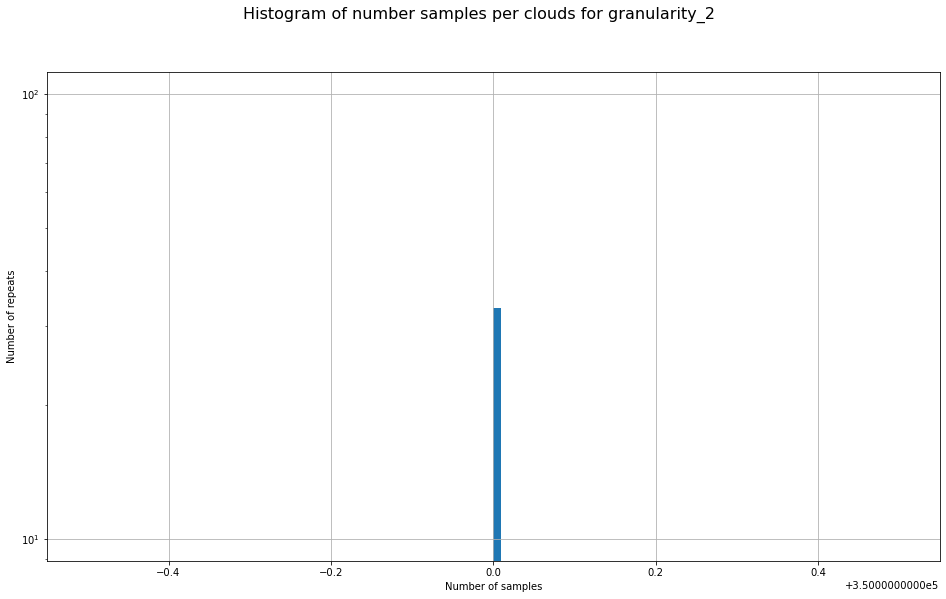

<Figure size 432x288 with 0 Axes>

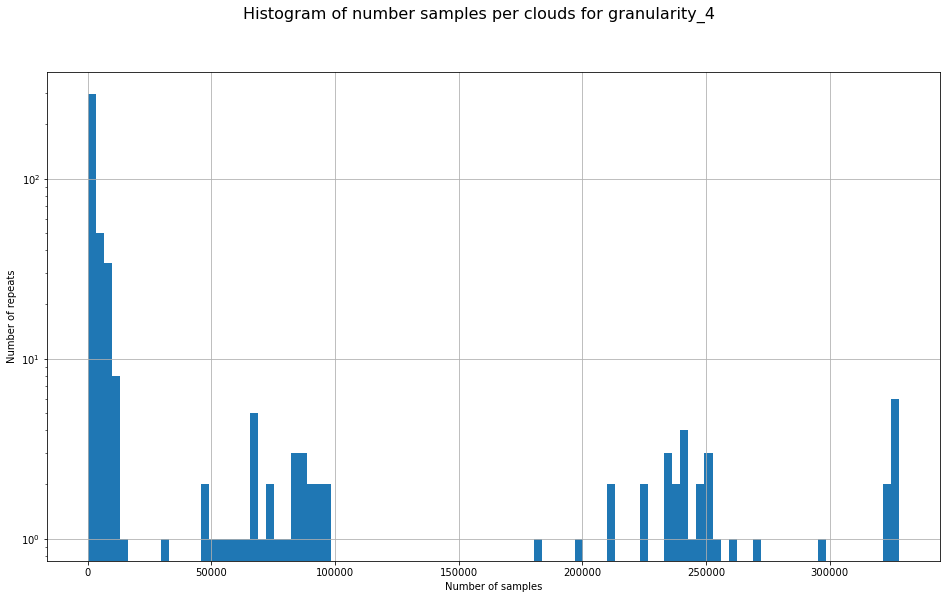

<Figure size 432x288 with 0 Axes>

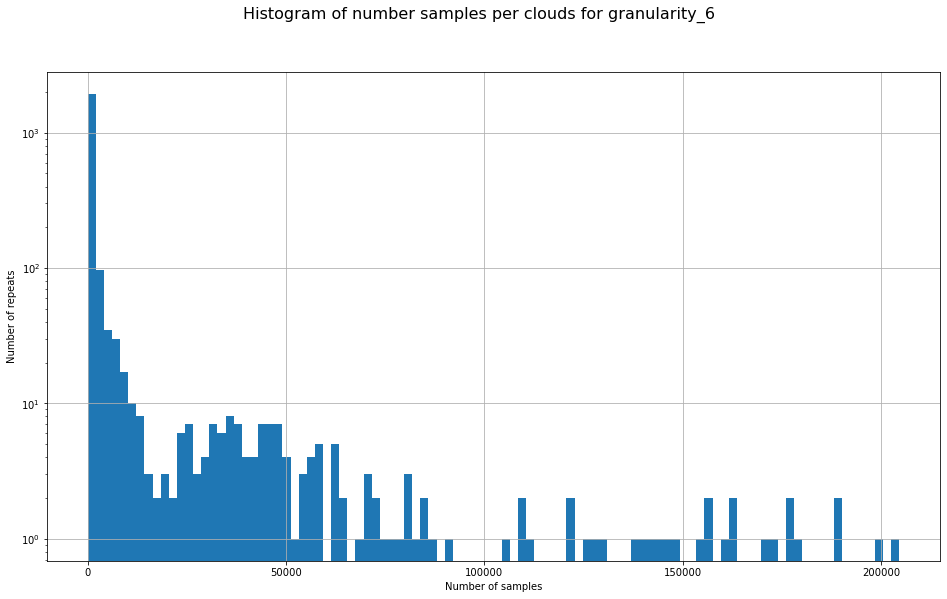

<Figure size 432x288 with 0 Axes>

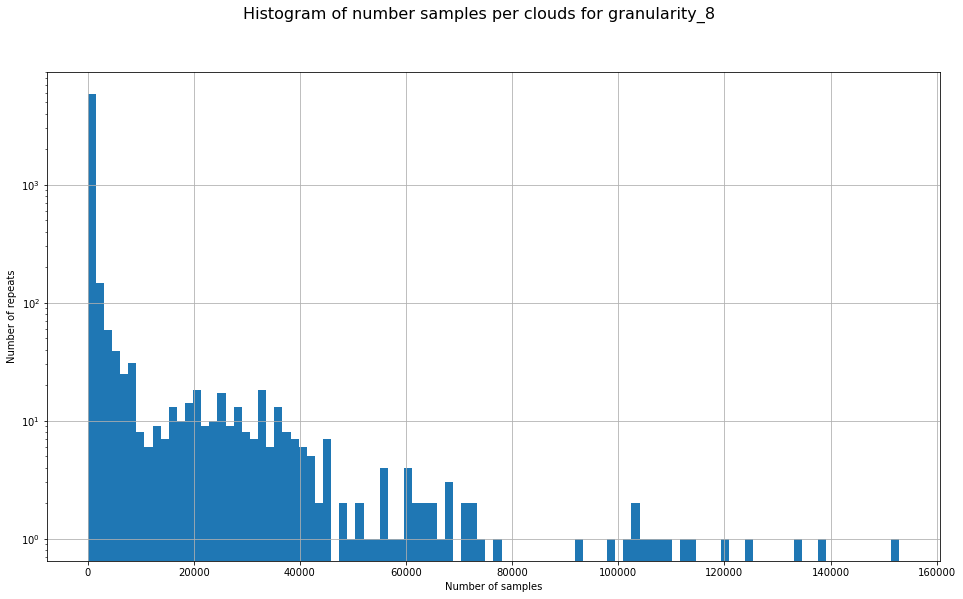

<Figure size 432x288 with 0 Axes>

In [22]:
### plot samples per clouds per granularity histogram

granularities = n_clouds.keys()

size_scaler = 1


for gra in granularities:

    data = n_samples[gra]['list']

    fig = plt.figure(figsize= (16 * size_scaler, 9 * size_scaler))

    ax = fig.subplots(1,1)

    ax.hist(data,bins=100,log=True)

    ax.set_ylabel('Number of repeats')

    ax.set_xlabel('Number of samples')

    ax.grid()

    fig.suptitle('Histogram of number samples per clouds for ' + gra, fontsize=16)

    plt.show()

    plt.savefig('figures/number_of_samples_per_cloud_for_each_' + gra + '.pdf',format='pdf')

    del fig



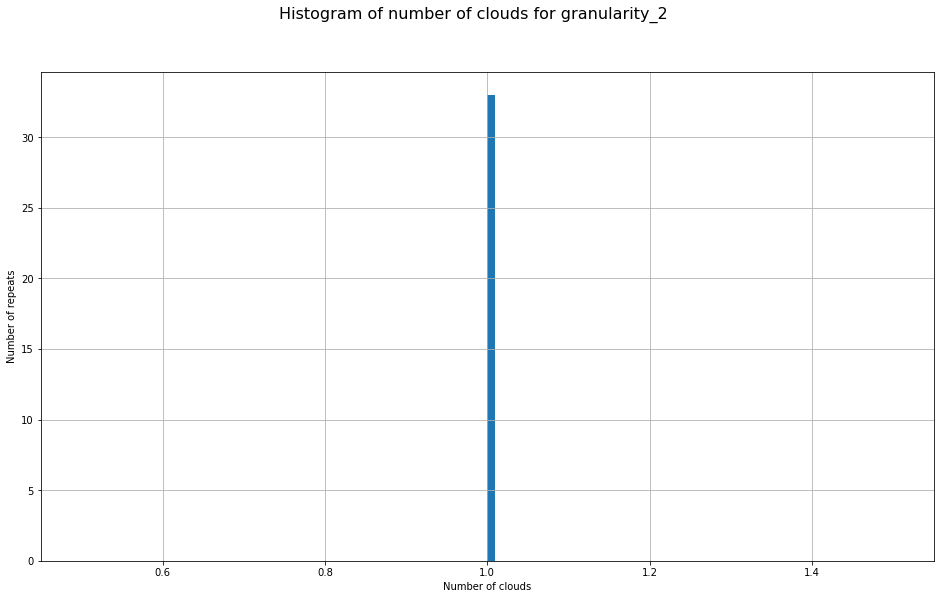

<Figure size 432x288 with 0 Axes>

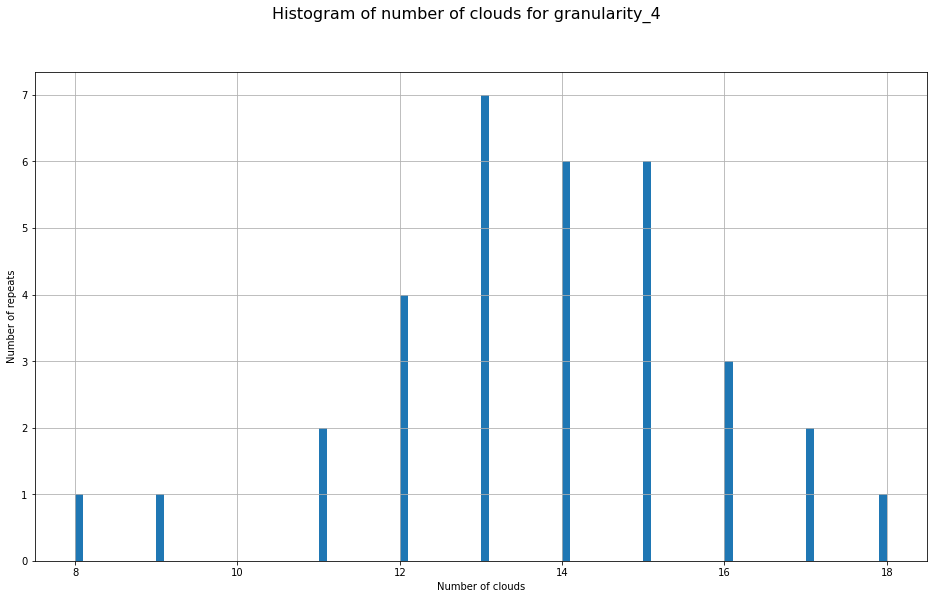

<Figure size 432x288 with 0 Axes>

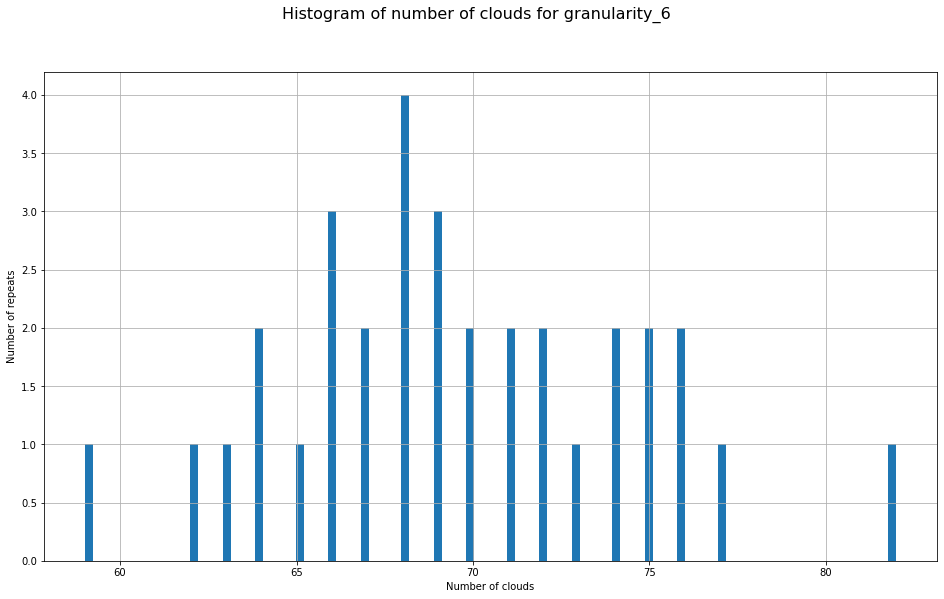

<Figure size 432x288 with 0 Axes>

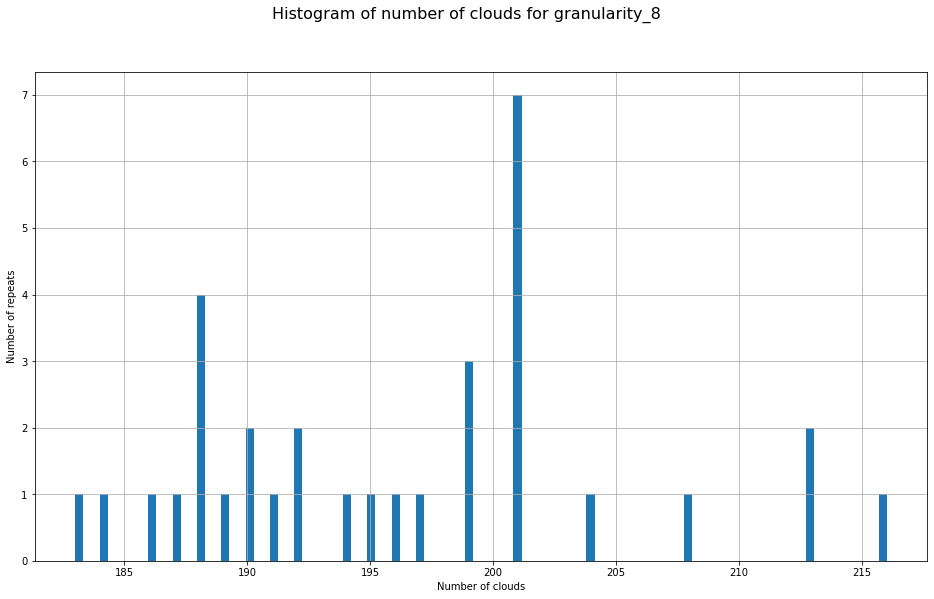

<Figure size 432x288 with 0 Axes>

In [15]:
### plot number of clouds per granularity histogram

granularities = n_clouds.keys()

size_scaler = 1


for gra in granularities:

    data = n_clouds[gra]['list']

    fig = plt.figure(figsize= (16 * size_scaler, 9 * size_scaler))

    ax = fig.subplots(1,1)

    ax.hist(data,bins=100)

    ax.set_ylabel('Number of repeats')

    ax.set_xlabel('Number of clouds')

    ax.grid()

    fig.suptitle('Histogram of number of clouds for ' + gra, fontsize=16)

    plt.show()

    plt.savefig('figures/number_of_clouds_for_each_' + gra + '.pdf',format='pdf')

    del fig



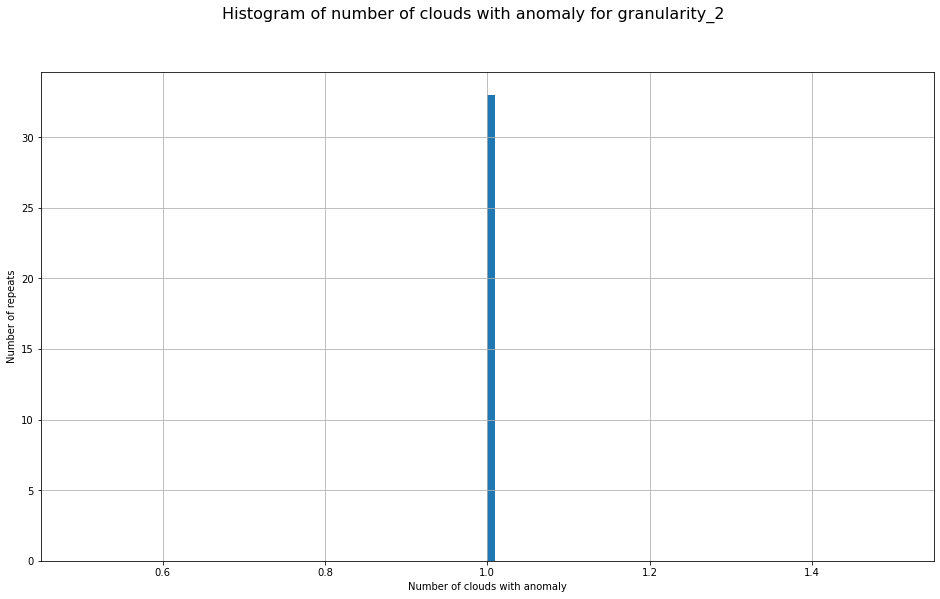

<Figure size 432x288 with 0 Axes>

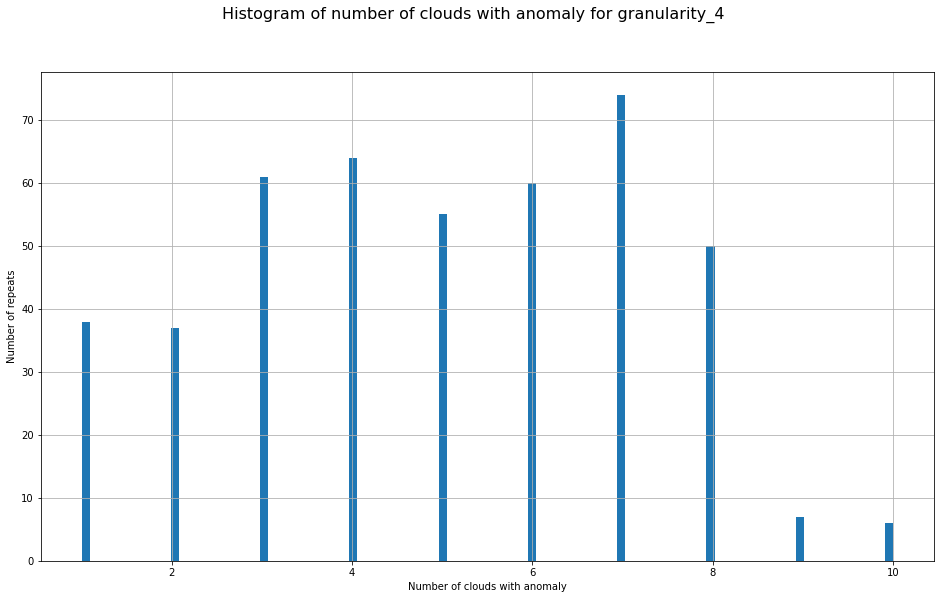

<Figure size 432x288 with 0 Axes>

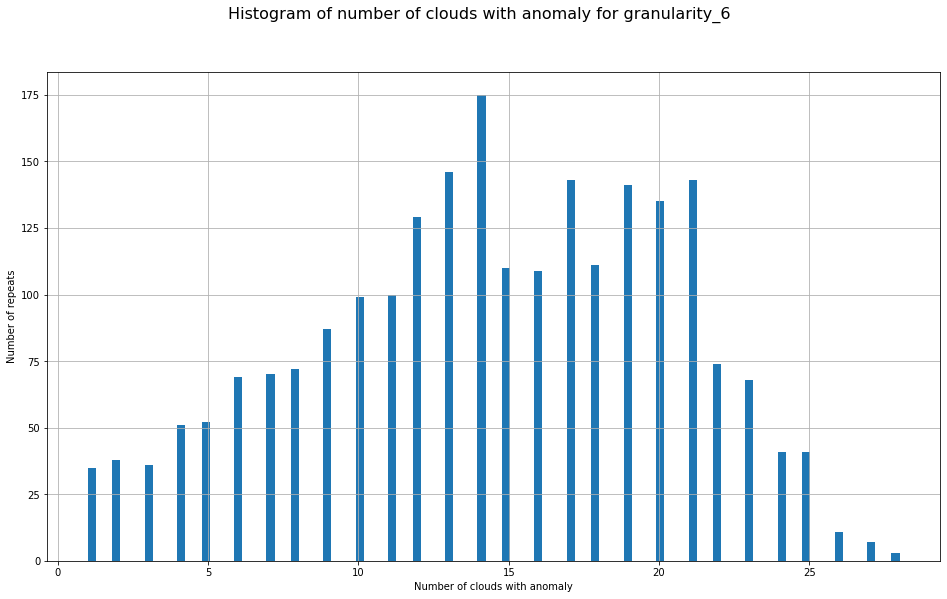

<Figure size 432x288 with 0 Axes>

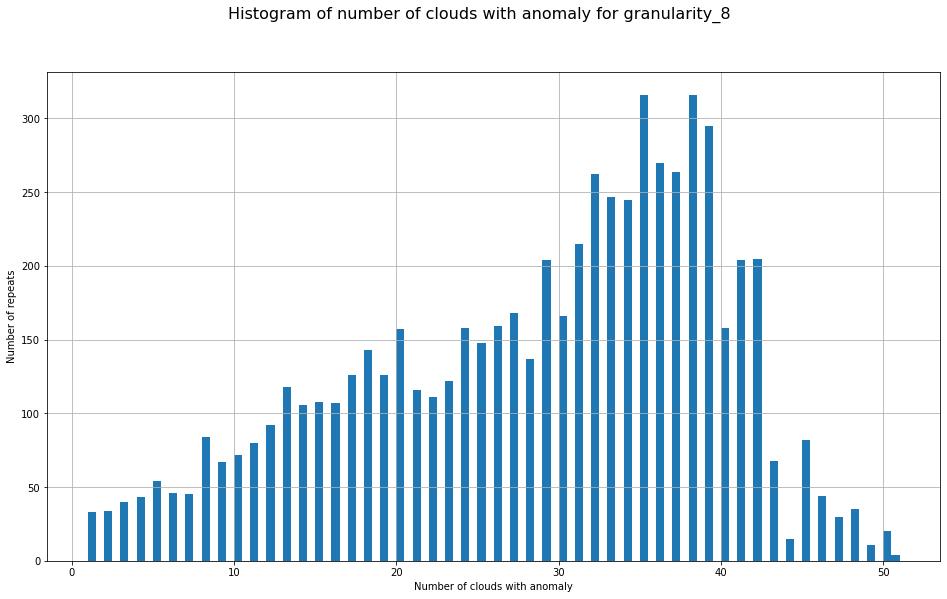

<Figure size 432x288 with 0 Axes>

In [17]:
### plot number of clouds with anomaly per granularity histogram

granularities = n_clouds.keys()

size_scaler = 1


for gra in granularities:

    data = anomaly_clouds[gra]['list']

    fig = plt.figure(figsize= (16 * size_scaler, 9 * size_scaler))

    ax = fig.subplots(1,1)

    ax.hist(data,bins=100)

    ax.set_ylabel('Number of repeats')

    ax.set_xlabel('Number of clouds with anomaly')

    ax.grid()

    fig.suptitle('Histogram of number of clouds with anomaly for ' + gra, fontsize=16)

    plt.show()

    plt.savefig('figures/number_of_clouds_with_anomaly_for' + gra + '.pdf',format='pdf')

    del fig


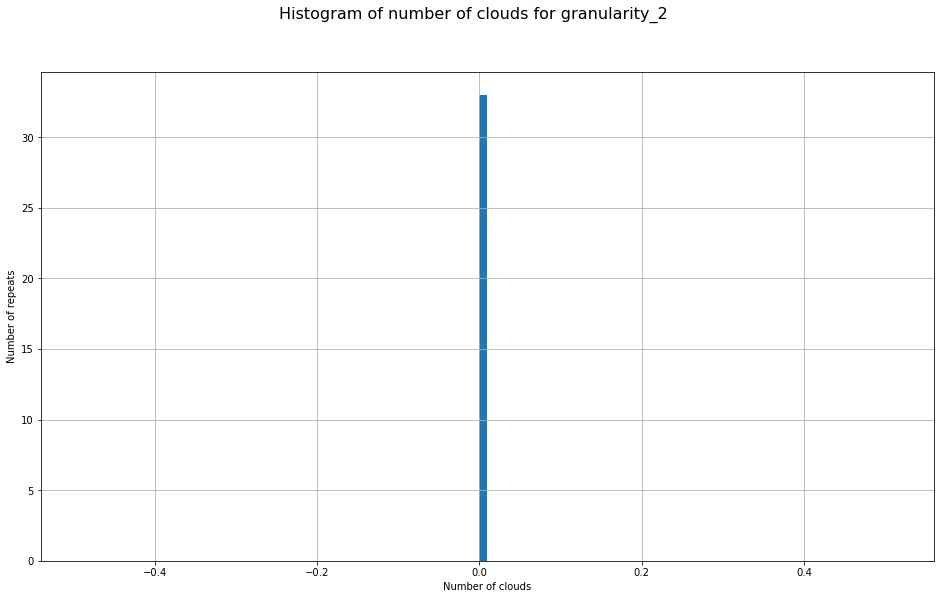

<Figure size 432x288 with 0 Axes>

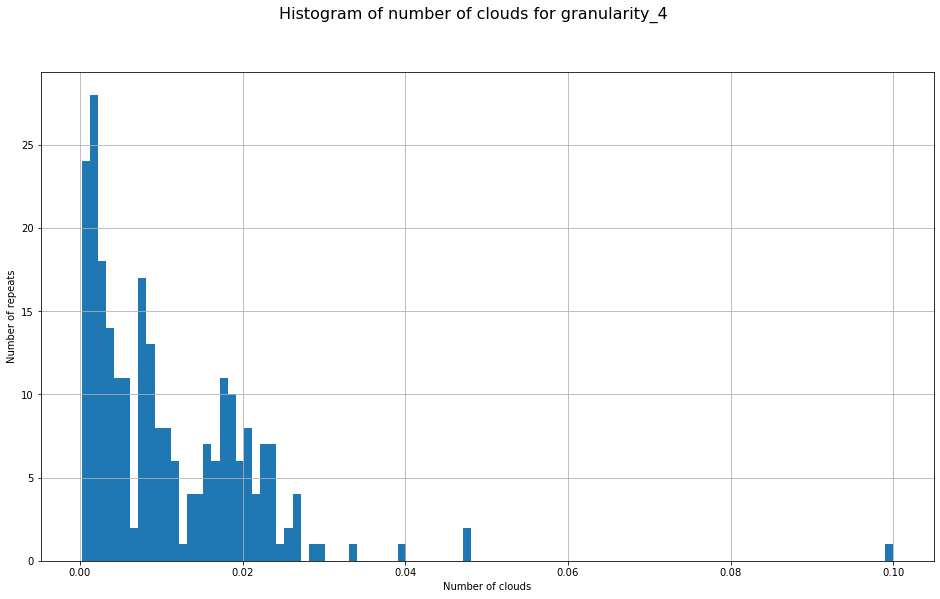

<Figure size 432x288 with 0 Axes>

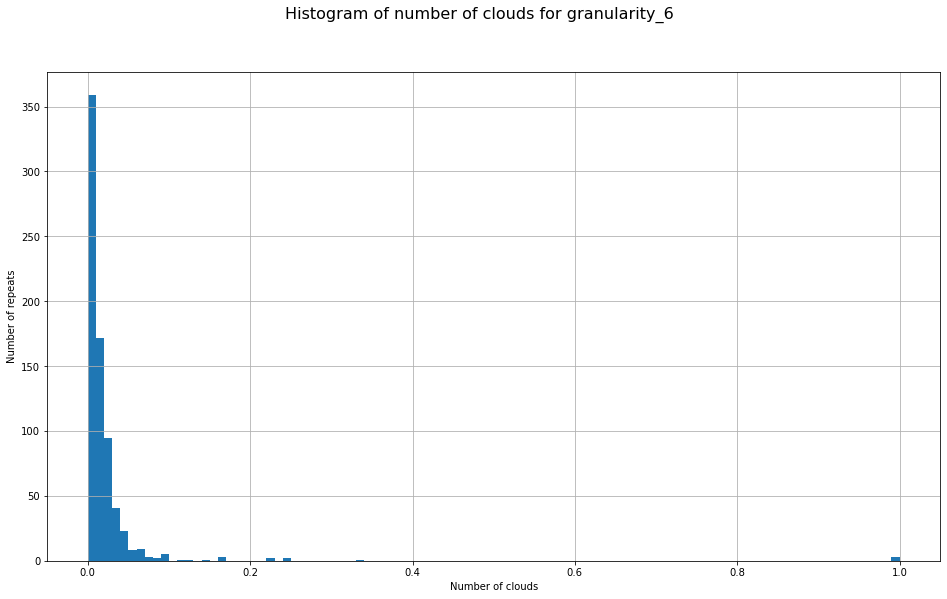

<Figure size 432x288 with 0 Axes>

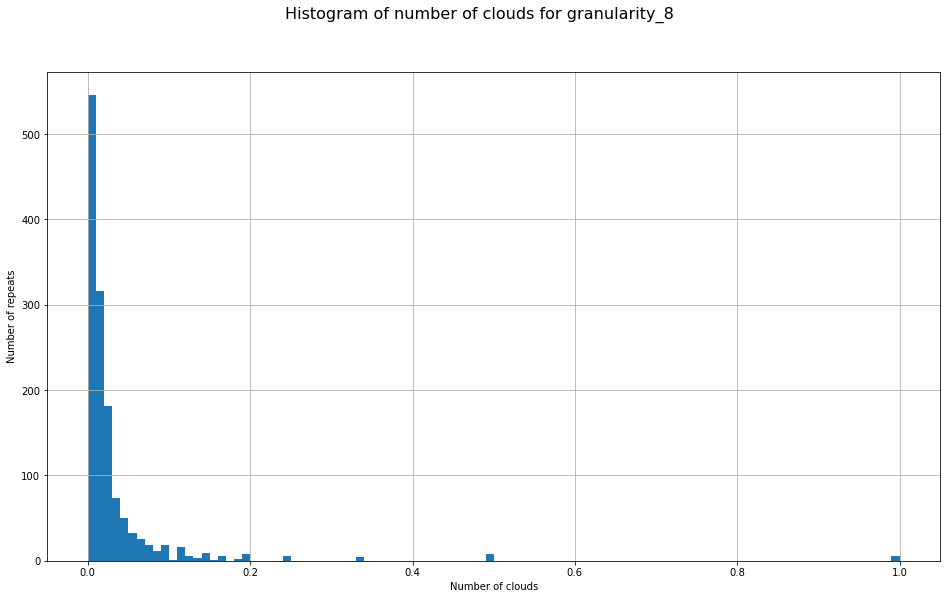

<Figure size 432x288 with 0 Axes>

In [16]:
### plot percentage of signal per granularity histogram

granularities = n_clouds.keys()

size_scaler = 1


for gra in granularities:

    data = signal_percent[gra]['list']

    fig = plt.figure(figsize= (16 * size_scaler, 9 * size_scaler))

    ax = fig.subplots(1,1)

    ax.hist(data,bins=100)

    ax.set_ylabel('Number of repeats')

    ax.set_xlabel('Percentage of signal')

    ax.grid()

    fig.suptitle('Histogram of percentage of signal for ' + gra, fontsize=16)

    plt.show()

    plt.savefig('figures/percentage_of_signal_for_' + gra + '.pdf',format='pdf')

    del fig



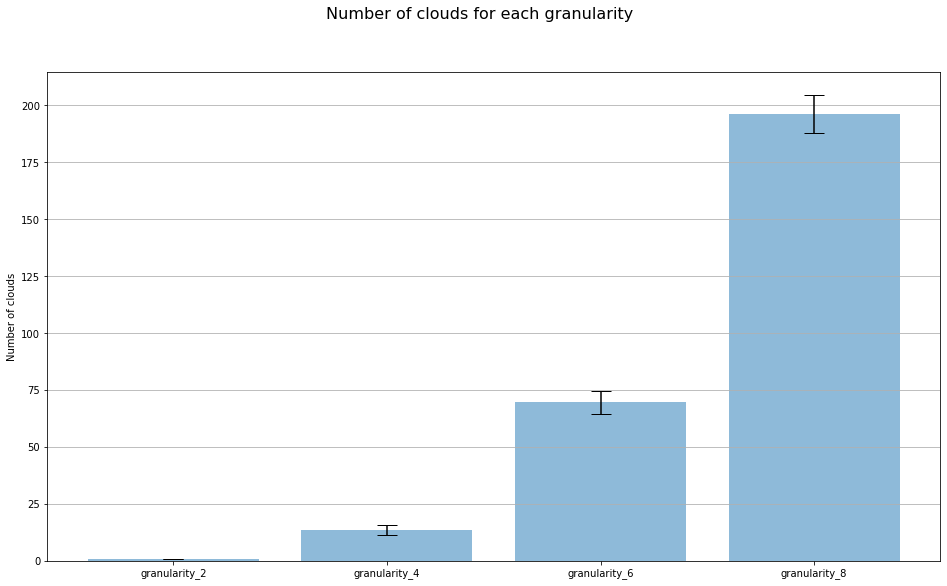

In [10]:
### plot number of clouds per granularity

granularities = n_clouds.keys()

n_clouds_mean = []

n_clouds_std = []

for gra in granularities:

    n_clouds_mean.append(n_clouds[gra]['mean'])

    n_clouds_std.append(n_clouds[gra]['std'])

x_pos = np.arange(len(granularities))

size_scaler = 1

fig = plt.figure(figsize= (16 * size_scaler, 9 * size_scaler))

ax = fig.subplots(1,1)

fig.suptitle('Number of clouds for each granularity', fontsize=16)

# Build the plot

ax.bar(x_pos, n_clouds_mean, yerr=n_clouds_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(granularities)
ax.set_ylabel('Number of clouds')

ax.yaxis.grid(True)

plt.savefig('figures/number_of_clouds_for_each_granularity.pdf',format='pdf')


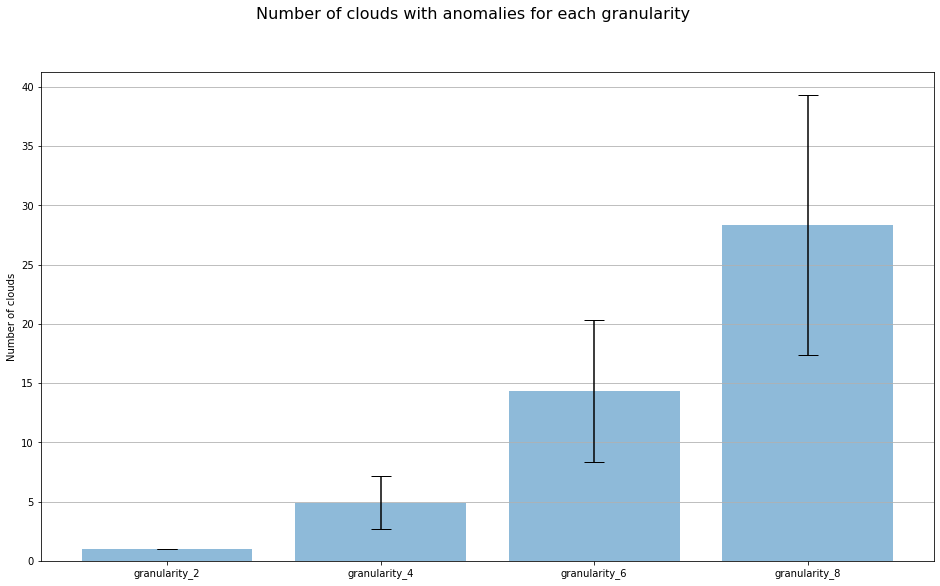

In [11]:
### plot number of clouds with aomaly per granularity

granularities = n_clouds.keys()

n_clouds_mean = []

n_clouds_std = []

for gra in granularities:

    n_clouds_mean.append(anomaly_clouds[gra]['mean'])

    n_clouds_std.append(anomaly_clouds[gra]['std'])

x_pos = np.arange(len(granularities))

size_scaler = 1

fig = plt.figure(figsize= (16 * size_scaler, 9 * size_scaler))

ax = fig.subplots(1,1)

fig.suptitle('Number of clouds with anomalies for each granularity', fontsize=16)

# Build the plot

ax.bar(x_pos, n_clouds_mean, yerr=n_clouds_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(granularities)
ax.set_ylabel('Number of clouds')

ax.yaxis.grid(True)

plt.savefig('figures/number_of_anomaly_clouds_for_each_granularity.pdf',format='pdf')

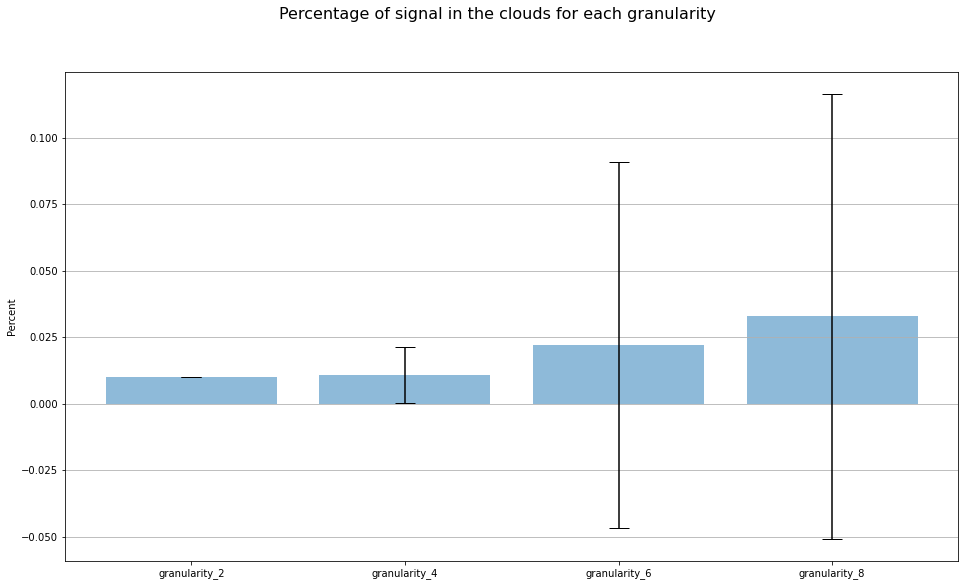

In [12]:
### plot percentage of signal per granularity

granularities = n_clouds.keys()

signal_percent_mean = []

signal_percent_std = []

for gra in granularities:

    signal_percent_mean.append(signal_percent[gra]['mean'])

    signal_percent_std.append(signal_percent[gra]['std'])

x_pos = np.arange(len(granularities))

size_scaler = 1

fig = plt.figure(figsize= (16 * size_scaler, 9 * size_scaler))

ax = fig.subplots(1,1)

fig.suptitle('Percentage of signal in the clouds for each granularity', fontsize=16)

# Build the plot

ax.bar(x_pos, signal_percent_mean, yerr=signal_percent_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(granularities)
ax.set_ylabel('Percent')

ax.yaxis.grid(True)

plt.savefig('figures/percentage_of_signal_in_the_clouds_for_each_granularity.pdf',format='pdf')


In [20]:
reload(SODA_numba)

<module 'SODA_numba' from '/home/thiago/Repositories/Learning/Python/SODA_study/SODA_numba.py'>

In [41]:
reload(SODA_numba)

<module 'SODA_numba' from '/home/thiago/Repositories/Learning/Python/SODA_study/SODA_numba.py'>

In [26]:
### calculating relative scores

names = [
    'euclidean',
    'cosine'
]


metrics_dict = {}


# Initializing progress bar

n_operations = int(len(outputs_dict.keys()) * len(outputs_dict['granularity_2'].keys())*350000)


# Initializing progress bar

bar = ProgBar(n_operations,'Calculating relative scores')


for gra in outputs_dict:

    for it in outputs_dict[gra]:

        metrics_dict[it] = {}

        # defining iteration in analisys

        it_int = int(it.split('_')[1])
        

        # get clouds reference

        IDX = outputs_dict[gra][it]['IDX']


        # get data used for the partitions

        data = divisions_dict[it_int]['train_df']

        y = divisions_dict[it_int]['train_labels']


        # separete signal from background

        background = data[y==0]
    
        signal = data[y==1]


        for i,name in enumerate(names):

            metrics_dict[it][name] = {
                'pairwise_score' : {
                    'general' : {
                        'cumulative_prox' : []
                    },
                    'signal_signal' : {
                        'cumulative_prox' : [],
                        'mean_prox' : [],
                        'std_prox' : []
                    },
                    'signal_background' : {
                        'cumulative_prox' : [],
                        'mean_prox' : [],
                        'std_prox' : []
                    }
                }
            }


        for i in range(len(data)):

            # Calculates the metric for all samples

            line = data[i].reshape(1, -1)

            score = SODA_numba.hand_dist(line,data[:])

            
            for j,name in enumerate(names):

                # compute the distance sum, mean and std between background and signal samples

                dist_sum = np.sum(score[:,j]**2)


                # concatenating results

                metrics_dict[it][name]['pairwise_score']['general']['cumulative_prox'].append(dist_sum)

            if i < n_signal:

                # Calculates signal-signal metrics

                line = signal[i].reshape(1, -1)
                
                score = SODA_numba.hand_dist(line,signal[:])

                for j,name in enumerate(names):

                    # compute the distance sum, mean and std between background and signal samples

                    dist_sum = np.sum(score[:,j]**2)

                    dsit_mean = np.mean((score[:,j]**2)**0.5)

                    dsit_std = np.std((score[:,j]**2)**0.5)


                    # concatenating results

                    metrics_dict[it][name]['pairwise_score']['signal_signal']['cumulative_prox'].append(dist_sum)

                    metrics_dict[it][name]['pairwise_score']['signal_signal']['mean_prox'].append(dsit_mean)

                    metrics_dict[it][name]['pairwise_score']['signal_signal']['std_prox'].append(dsit_std)


                # Calculates signal-background metrics
                
                score = SODA_numba.hand_dist(line,background[:])

                for j,name in enumerate(names):

                    # compute the distance sum, mean and std between background and signal samples

                    dist_sum = np.sum(score[:,j]**2)
                    
                    dsit_mean = np.mean(((score[:,j])**2)**0.5)

                    dsit_std = np.std(((score[:,j])**2)**0.5)


                    # concatenating results

                    metrics_dict[it][name]['pairwise_score']['signal_background']['cumulative_prox'].append(dist_sum)

                    metrics_dict[it][name]['pairwise_score']['signal_background']['mean_prox'].append(dsit_mean)

                    metrics_dict[it][name]['pairwise_score']['signal_background']['std_prox'].append(dsit_std)

            bar.update()


Calculating relative scores
[                                                 ] 0.00% - 610 of 46200000

KeyboardInterrupt: 

# Testing distances

In [ ]:
### calculing pi_caculator cumulative proximity

UN, W = X.shape

Xnorm = np.matrix(np.sqrt(np.sum(np.power(X,2),axis=1))).T
aux2 = Xnorm

for i in range(W-1):
    aux2 = np.insert(aux2,0,Xnorm.T,axis=1)

X1 = X / aux2
AA2 = np.mean(X1,0)
X2 = 1
DT2 = X2 - np.sum(np.power(AA2,2))
aux = []
for i in range(UN): aux.append(AA2)
aux2 = [X1[i]-aux[i] for i in range(UN)]
pi_caculator_prox = np.sum(np.sum(np.power(aux2,2),axis=1),axis=1)+DT2

In [ ]:
### calculing SODA_numba.hand_dist cumulative proximity

L, W = X.shape
distance = np.zeros((L,L))

for i in range(L):
    for j in range(L):

        dot = 0
        denom_a = 0
        denom_b = 0

        for k in range(W):

            dot += (X[i,k]*X[j,k])
            denom_a += X[i,k]**2
            denom_b += X[j,k]**2

        cos_similarity = dot / ((denom_a ** 0.5) * (denom_b ** 0.5))

        distance[i,j] = 1 - cos_similarity

SODA_numba.hand_dist_prox = np.sum(distance**2,axis=1)

In [ ]:
### calculing cosine_distance cumulative proximity

distance = cosine_distances(X)

cosine_distance_prox = np.sum(distance**2,axis=1)

In [ ]:
### calculing cosine_similarity cumulative proximity

distance = cosine_similarity(X)

cosine_similarity_prox = np.sum(distance**2,axis=1)

In [ ]:
### calculing euclidean_distance cumulative proximity

distance = euclidean_distances(X)

euclidean_distance_prox = np.sum(distance**2,axis=1)

In [ ]:
### comparing pi_caculator with cosine_distance

diff = cosine_distance_prox - pi_caculator_prox

print('difference = {:.2e} +/- {:.2e}'.format(np.mean(diff),np.std(diff)))

difference = 5.60e-01 +/- 2.91e-01


In [ ]:
### comparing pi_caculator with cosine_similarity

diff = cosine_similarity_prox - pi_caculator_prox

print('difference = {:.2e} +/- {:.2e}'.format(np.mean(diff),np.std(diff)))

difference = 1.37e+02 +/- 4.50e+00


In [ ]:
### comparing SODA_numba.hand_dist with cosine_similarity

diff = cosine_similarity_prox - SODA_numba.hand_dist_prox

print('difference = {:.2e} +/- {:.2e}'.format(np.mean(diff),np.std(diff)))

difference = 1.37e+02 +/- 4.78e+00


In [ ]:
### comparing SODA_numba.hand_dist with cosine_distance

diff = cosine_distance_prox - SODA_numba.hand_dist_prox

print('difference = {:.2e} +/- {:.2e}'.format(np.mean(diff),np.std(diff)))

difference = 3.18e-16 +/- 1.08e-15


In [ ]:
### defining new pi calculator

def pi_calculator(Uniquesample, mode):
    
    '''
    # Cumulative Proximity in recursive version
    # Section 2.2.i of SODA
    '''
    
    if mode == 'euclidean':

        L, W = Uniquesample.shape
        distance = np.zeros((L))

        uspi = []

        for i in range(L):

            for j in range(L):

                norm = 0

                for k in range(W): norm += (Uniquesample[i,k]-Uniquesample[j,k])**2

                euclidean_distance = norm**0.5

                distance[j] = euclidean_distance

            uspi.append(np.sum(distance**2,axis=0))


    if mode == 'cosine':

        L, W = Uniquesample.shape
        distance = np.zeros((L))

        uspi = []

        for i in range(L):

            for j in range(L):

                dot = 0
                denom_a = 0
                denom_b = 0

                for k in range(W):

                    dot += (Uniquesample[i,k]*Uniquesample[j,k])
                    denom_a += Uniquesample[i,k]**2
                    denom_b += Uniquesample[j,k]**2

                cos_similarity = dot / ((denom_a ** 0.5) * (denom_b ** 0.5))

                distance[j] = 1 - cos_similarity

            uspi.append(np.sum(distance**2,axis=0))
        
    return uspi

In [ ]:
### testing new function 

ld1 = pi_calculator(X,'euclidean')

ld2 = pi_calculator(X,'cosine')

diff1 = euclidean_distance_prox - ld1

print('difference = {:.2e} +/- {:.2e}'.format(np.mean(diff1),np.std(diff1)))

diff2 = cosine_distance_prox - ld2

print('difference = {:.2e} +/- {:.2e}'.format(np.mean(diff1),np.std(diff1)))

difference = 5.38e-13 +/- 7.22e-13
difference = 5.38e-13 +/- 7.22e-13


# Testing SODA modifications

In [ ]:
reload(SODA_numba)

NameError: name 'SODA_numba' is not defined

In [ ]:
import SODA_numba

SODA_input = {
    'StaticData' : X,
    'GridSize' : 5,
    'DistanceType' : 'euclidean'
}

output = SODA_numba.SelfOrganisedDirectionAwareDataPartitioning(SODA_input)

target = np.array(output['IDX'])

In [ ]:
np.unique(target)

array([1, 2])

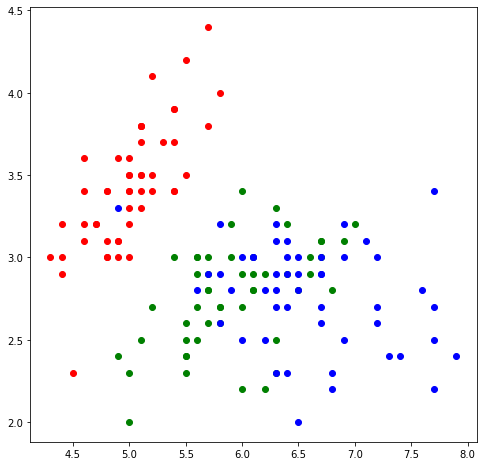

In [ ]:
plt.figure(figsize=(8, 8))

plt.scatter(X[Y==0,0],X[Y==0,1],color='r')
plt.scatter(X[Y==1,0],X[Y==1,1],color='g')
plt.scatter(X[Y==2,0],X[Y==1,1],color='b')

plt.show()

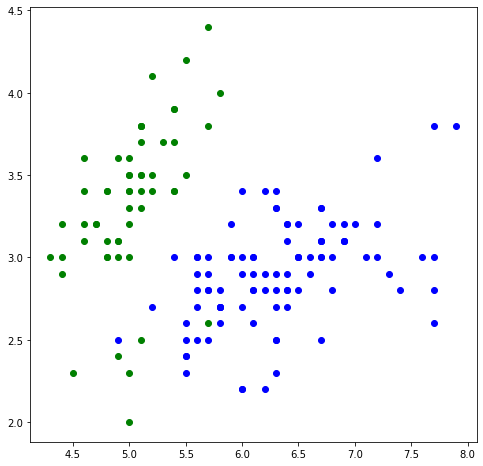

In [ ]:
plt.figure(figsize=(8, 8))

plt.scatter(X[target==1,0],X[target==1,1],color='g')
plt.scatter(X[target==2,0],X[target==2,1],color='b')

plt.show()